In [49]:
pip install torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from pathlib import Path
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


In [14]:
data_dir = Path("Data")  

class_names = sorted([folder.name for folder in data_dir.iterdir() if folder.is_dir()])
print("Classes:", class_names)


Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [15]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # <- Force grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [7]:
import matplotlib.pyplot as plt

In [41]:
# Create the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

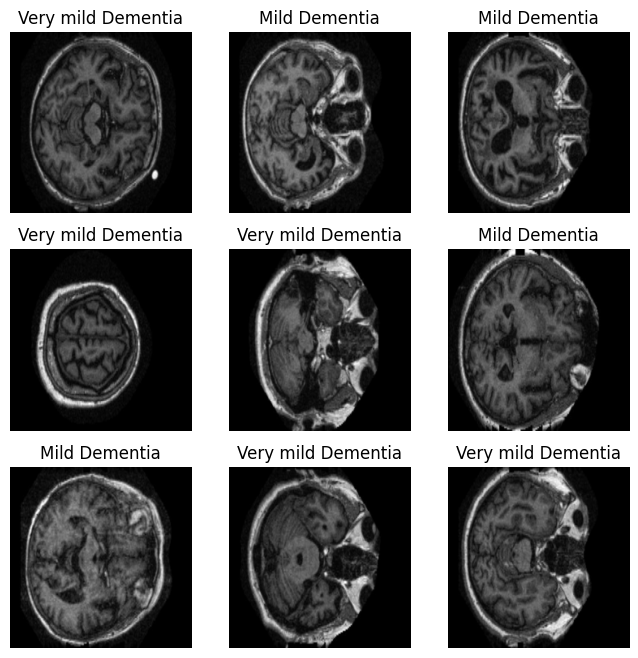

In [42]:
images, labels = next(iter(dataloader))
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i][0], cmap='gray')  # [0] because it's grayscale
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [1]:
pip install torch-directml --force-reinstall


  Using cached torch_directml-0.2.5.dev240914-cp310-cp310-win_amd64.whl (9.0 MB)
  Using cached torchvision-0.19.1-cp310-cp310-win_amd64.whl (1.3 MB)
  Using cached torch-2.4.1-cp310-cp310-win_amd64.whl (199.4 MB)
  Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl (45 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     ---------- ----------------------------- 1.6/6.2 MB 49.9 MB/s eta 0:00:01
     ------------------------------------ --- 5.7/6.2 MB 91.3 MB/s eta 0:00:01
     ---------------------------------------- 6.2/6.2 MB 79.2 MB/s eta 0:00:00
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached pillow-11.2.1-cp310-cp310-win_amd64.whl (2.7 MB)
  Using cached numpy-2.2.4-cp310-cp310-win_amd64.whl (12.9 MB)
  Using cached MarkupSafe-3.0.2-cp310-cp310-win_amd64.whl (15 k

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import torch_directml
from torchvision import models
from torch import nn

In [44]:
# 1. Select the AMD GPU via DirectML
device = torch_directml.device(1)

# 2. Load pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# 3. Change the first conv layer to accept 1-channel grayscale MRI images
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# 4. Change the last layer to output number of classes (e.g., 4 classes)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # make sure `class_names` is defined earlier

# 5. Send model to AMD GPU
model = model.to(device)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [46]:
dummy_input = torch.randn(128, 1, 224, 224).to(device)
model.eval()
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)


In [47]:
import torch_directml

for i in range(torch_directml.device_count()):
    dml_device = torch_directml.device(i)
    print(f"Device {i}:", dml_device)


Device 0: privateuseone:0
Device 1: privateuseone:1


In [38]:
pip install tqdm


     ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
     ---------------------------------------- 78.5/78.5 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
from tqdm import tqdm


In [48]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap the dataloader with tqdm for a progress bar
    for inputs, labels in tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass + optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch [1/5]: 100%|██████████| 86/86 [00:29<00:00,  2.91it/s]


Epoch [1/5] - Loss: 1.2711, Accuracy: 61.22%


Epoch [2/5]: 100%|██████████| 86/86 [00:28<00:00,  3.02it/s]


Epoch [2/5] - Loss: 0.9756, Accuracy: 62.79%


Epoch [3/5]: 100%|██████████| 86/86 [00:28<00:00,  3.02it/s]


Epoch [3/5] - Loss: 0.9739, Accuracy: 62.79%


Epoch [4/5]: 100%|██████████| 86/86 [00:28<00:00,  3.01it/s]


Epoch [4/5] - Loss: 0.9707, Accuracy: 62.79%


Epoch [5/5]: 100%|██████████| 86/86 [00:28<00:00,  3.02it/s]

Epoch [5/5] - Loss: 0.9972, Accuracy: 62.19%


In [30]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass + optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


KeyboardInterrupt: 